# 4. Base Model

a. Train a simple model (e.g., Logistic Regression) to set a benchmark for 
model performance. <br>
b.  Evaluate its performance on key metrics (e.g., accuracy, precision, 
recall, F1-score).

#### Importing the relevant modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           accuracy_score, precision_score, recall_score, f1_score)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and prepare the data
csv_path = Path("dataset.csv")
df = pd.read_csv(csv_path)

# Handle missing values in target
target_col = "Label"
x = df.drop(columns=[target_col])
y = df[target_col]

# Remove rows with missing target values
mask = ~y.isna()
x_clean = x[mask]
y_clean = y[mask]

print(f"Dataset shape: {x_clean.shape}")
print(f"Target distribution:\n{y_clean.value_counts()}")
print(f"Fraud percentage: {y_clean.mean()*100:.2f}%")


Dataset shape: (20499, 14)
Target distribution:
Label
0.0    20107
1.0      392
Name: count, dtype: int64
Fraud percentage: 1.91%


In [3]:
# Set up preprocessing pipeline
num_col = selector(dtype_include=["int64", "float64"])(x_clean)
cat_col = selector(dtype_include=["object","category",'bool'])(x_clean)

print(f"Numerical columns: {num_col}")
print(f"Categorical columns: {cat_col}")

# Preprocessing pipelines
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_col),
        ("cat", cat_pipe, cat_col)
    ],
    remainder="drop"
)


Numerical columns: ['Sender_Sector', 'USD_amount']
Categorical columns: ['Time_step', 'Transaction_Id', 'Sender_Id', 'Sender_Account', 'Sender_Country', 'Sender_Gender', 'Sender_lob', 'Bene_Id', 'Bene_Account', 'Bene_Country', 'Bene_Gender', 'Transaction_Type']


In [4]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(
    x_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"Training set: {x_train.shape}")
print(f"Test set: {x_test.shape}")
print(f"Training fraud rate: {y_train.mean()*100:.2f}%")
print(f"Test fraud rate: {y_test.mean()*100:.2f}%")


Training set: (16399, 14)
Test set: (4100, 14)
Training fraud rate: 1.91%
Test fraud rate: 1.90%


In [ ]:
# Creating and training logistic regression model
# Using class_weight='balanced' to handle class imbalance
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", LogisticRegression(
        random_state=42,
        class_weight='balanced',  # Handles class imbalance
        max_iter=1000
    ))
])

# Train the model
print("Training logistic regression model...")
model.fit(x_train, y_train)
print("Training completed!")


Training logistic regression model...
Training completed!


In [ ]:
# Making predictions
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]  # Probability of fraud

print("Predictions completed!")
print(f"Predicted fraud cases: {y_pred.sum()}")
print(f"Actual fraud cases: {y_test.sum()}")


Predictions completed!
Predicted fraud cases: 98.0
Actual fraud cases: 78.0


In [ ]:
# Calculating key performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print("=== LOGISTIC REGRESSION BENCHMARK RESULTS ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc_score:.4f}")
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))


=== LOGISTIC REGRESSION BENCHMARK RESULTS ===
Accuracy:  0.9600
Precision: 0.0612
Recall:    0.0769
F1-Score:  0.0682
AUC-ROC:   0.7235

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      4022
       Fraud       0.06      0.08      0.07        78

    accuracy                           0.96      4100
   macro avg       0.52      0.53      0.52      4100
weighted avg       0.96      0.96      0.96      4100



In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("=== CONFUSION MATRIX ===")
print("                 Predicted")
print("Actual    Normal    Fraud")
print(f"Normal    {cm[0,0]:6d}    {cm[0,1]:5d}")
print(f"Fraud     {cm[1,0]:6d}    {cm[1,1]:5d}")

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print(f"\nSpecificity: {specificity:.4f}")
print(f"True Positive Rate (Recall): {recall:.4f}")
print(f"False Positive Rate: {fp/(fp+tn):.4f}")


=== CONFUSION MATRIX ===
                 Predicted
Actual    Normal    Fraud
Normal      3930       92
Fraud         72        6

Specificity: 0.9771
True Positive Rate (Recall): 0.0769
False Positive Rate: 0.0229


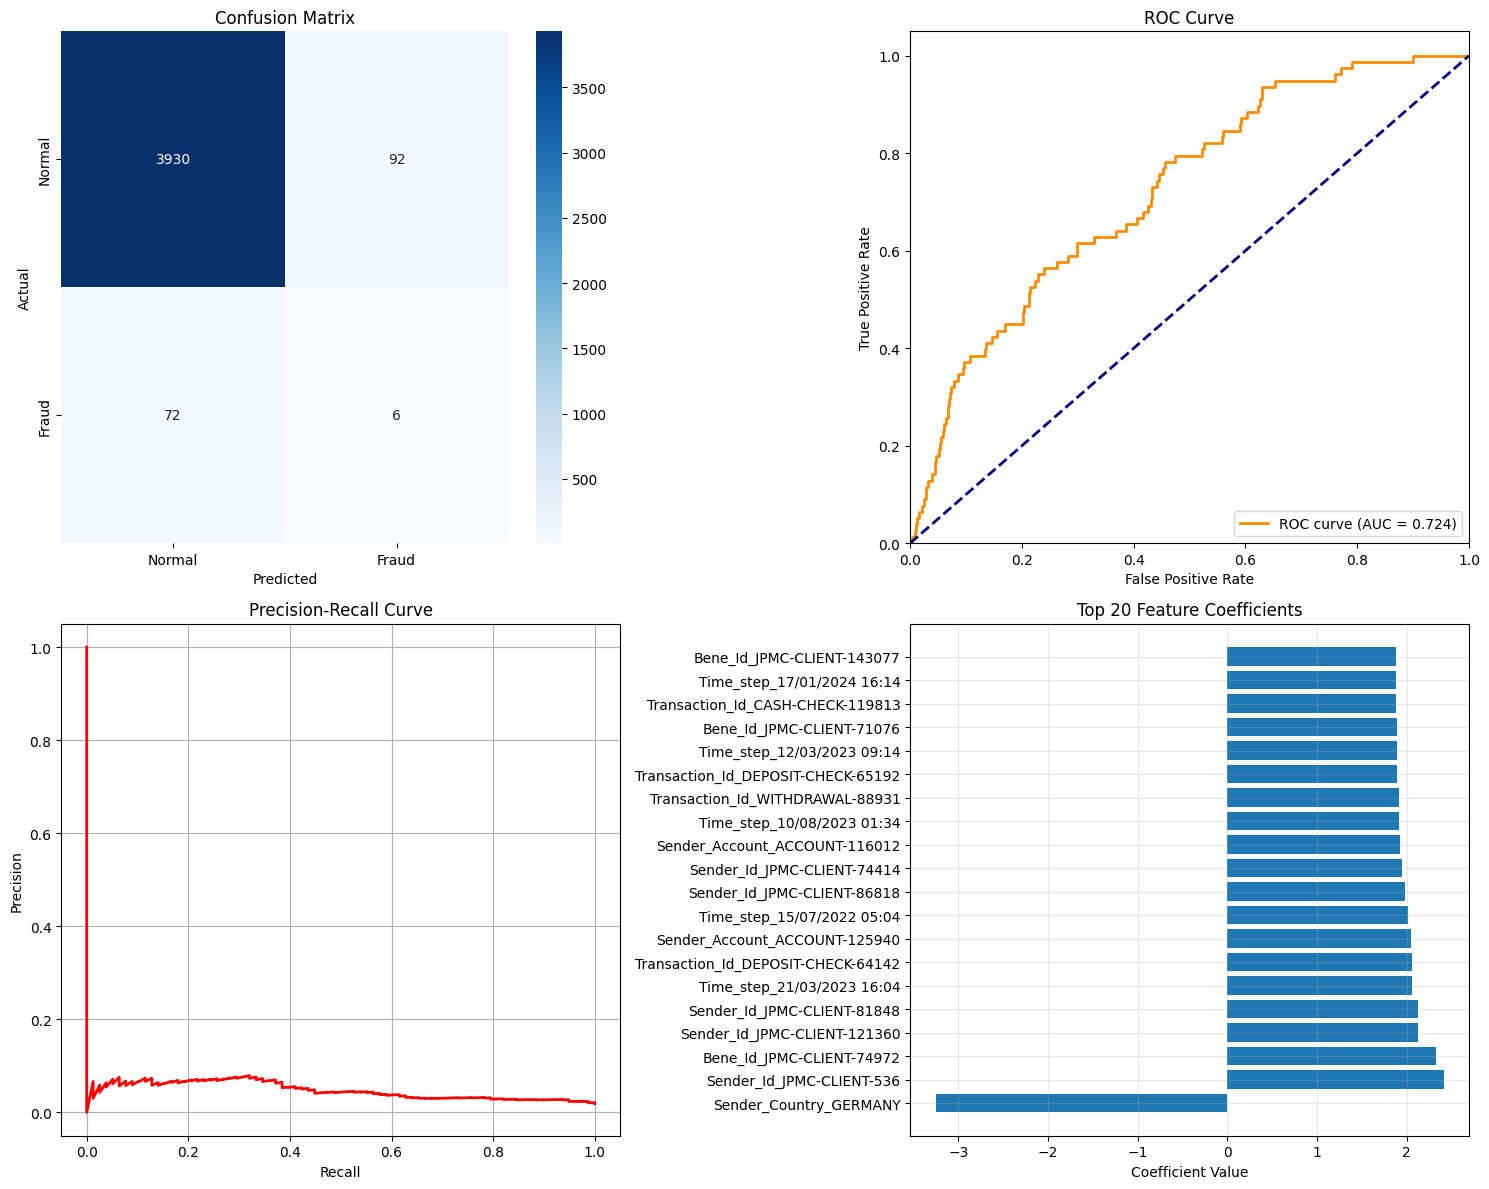

In [9]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], 
            yticklabels=['Normal', 'Fraud'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, 
               label=f'ROC curve (AUC = {auc_score:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc="lower right")

# 3. Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
axes[1,0].plot(recall_curve, precision_curve, color='red', lw=2)
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curve')
axes[1,0].grid(True)

# 4. Feature Importance (for logistic regression coefficients)
# Get feature names after preprocessing
feature_names = (num_col + 
                list(model.named_steps['preprocess']
                    .named_transformers_['cat']
                    .named_steps['ohe']
                    .get_feature_names_out(cat_col)))

# Get coefficients
coefficients = model.named_steps['classifier'].coef_[0]

# Sort by absolute value and take top 20
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', key=abs, ascending=False).head(20)

axes[1,1].barh(range(len(feature_importance)), feature_importance['coefficient'])
axes[1,1].set_yticks(range(len(feature_importance)))
axes[1,1].set_yticklabels(feature_importance['feature'])
axes[1,1].set_xlabel('Coefficient Value')
axes[1,1].set_title('Top 20 Feature Coefficients')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# Summary and Interpretation
print("=== BENCHMARK MODEL SUMMARY ===")
print(f"Model: Logistic Regression with balanced class weights")
print(f"Dataset: {x_clean.shape[0]} samples, {x_clean.shape[1]} features")
print(f"Fraud rate: {y_clean.mean()*100:.2f}% (highly imbalanced)")
print(f"\nKey Performance Metrics:")
print(f"• AUC-ROC: {auc_score:.3f} - Overall model performance")
print(f"• Precision: {precision:.3f} - Of predicted frauds, {precision*100:.1f}% are actually fraud")
print(f"• Recall: {recall:.3f} - Of actual frauds, {recall*100:.1f}% are detected")
print(f"• F1-Score: {f1:.3f} - Balance between precision and recall")
print(f"• Accuracy: {accuracy:.3f} - Overall correctness")

print(f"\n=== INTERPRETATION ===")
if auc_score > 0.8:
    print("✓ Good model performance (AUC > 0.8)")
elif auc_score > 0.7:
    print("⚠ Moderate model performance (AUC > 0.7)")
else:
    print("✗ Poor model performance (AUC < 0.7)")

if recall > 0.7:
    print("✓ Good fraud detection rate")
else:
    print("⚠ Low fraud detection rate - consider threshold tuning")

print(f"\nThis serves as a baseline for comparing more complex models.")
print(f"Next steps: Try Random Forest, XGBoost, or neural networks.")


=== BENCHMARK MODEL SUMMARY ===
Model: Logistic Regression with balanced class weights
Dataset: 20499 samples, 14 features
Fraud rate: 1.91% (highly imbalanced)

Key Performance Metrics:
• AUC-ROC: 0.724 - Overall model performance
• Precision: 0.061 - Of predicted frauds, 6.1% are actually fraud
• Recall: 0.077 - Of actual frauds, 7.7% are detected
• F1-Score: 0.068 - Balance between precision and recall
• Accuracy: 0.960 - Overall correctness

=== INTERPRETATION ===
⚠ Moderate model performance (AUC > 0.7)
⚠ Low fraud detection rate - consider threshold tuning

This serves as a baseline for comparing more complex models.
Next steps: Try Random Forest, XGBoost, or neural networks.
